# NICE-flow for optimum calibration for multiclass classification

In [1]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

from utils.data import get_cifar10, get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary
from calibrators import PAVCalibrator, MLRCalibrator, NiceCalibrator, TempScalingCalibrator

In [2]:
%matplotlib inline
np.random.seed(1)

In [3]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

## Analysis on CIFAR3

Load dataset and logits:

In [4]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

Calibrate the model:

Temperature scaling fitted in 0.027s
MLR fitted in 0.024s
PAV fitted in 0.003s
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NICE-flow fitted in 206.126s


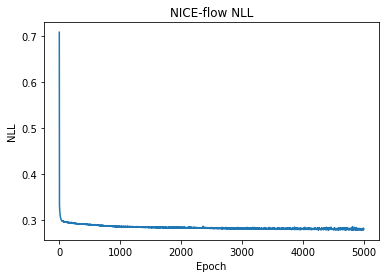

In [5]:
# Temp-scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, target)
print('Temperature scaling fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
mlr_cal = MLRCalibrator(logits, target)
print('MLR fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
pav_cal = PAVCalibrator(logits, target)
print('PAV fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal = NiceCalibrator(logits, target, layers=4, hidden_size=[4, 4],
                          version=2, epochs=5000)
print('NICE-flow fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

Compute calibration performance:

In [6]:
# Uncalibrated model
base_ece = expected_calibration_error(probs, target)
base_nll = neg_log_likelihood(probs, target)

# Temp-scaling
temp_probs = temp_cal.predict(logits)
temp_ece = expected_calibration_error(temp_probs, target)
temp_nll = neg_log_likelihood(temp_probs, target)

# MLR
mlr_probs = mlr_cal.predict(logits)
mlr_ece = expected_calibration_error(mlr_probs, target)
mlr_nll = neg_log_likelihood(mlr_probs, target)

# PAV
pav_probs = pav_cal.predict(logits)
pav_ece = expected_calibration_error(pav_probs, target)
pav_nll = neg_log_likelihood(pav_probs, target)

# NICE
nice_probs = nice_cal.predict(logits)
nice_ece = expected_calibration_error(nice_probs, target)
nice_nll = neg_log_likelihood(nice_probs, target)

Judge calibration:

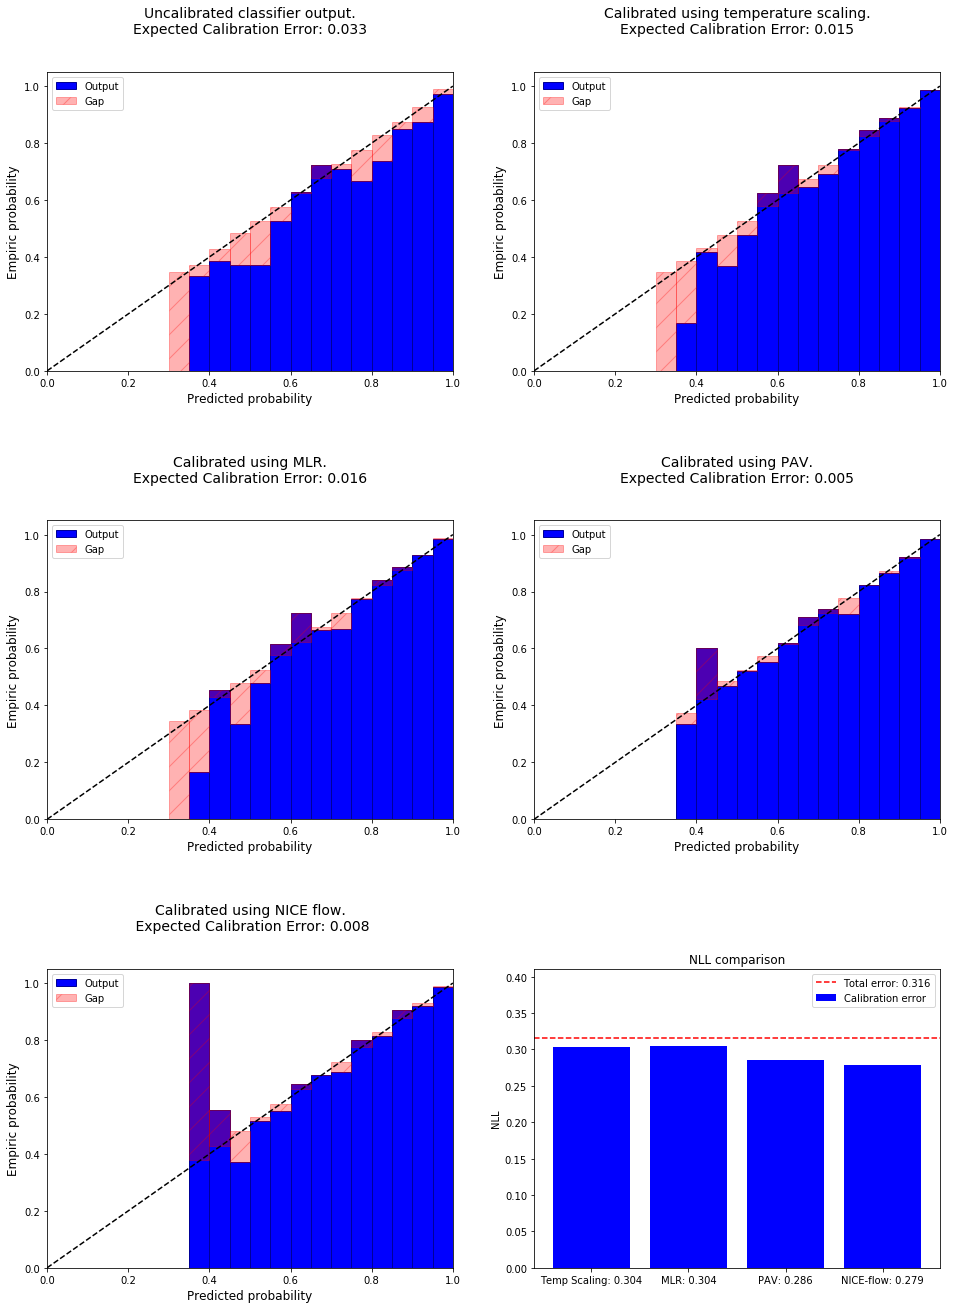

In [12]:
fig, ax_arr = plt.subplots(3, 2, figsize=(16, 22), gridspec_kw={'hspace': 0.5})
ax_arr[0, 0] = reliability_diagram(probs, target, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(base_ece), fontsize=12);
ax_arr[0, 1] = reliability_diagram(temp_probs, target, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(temp_ece), fontsize=12);
ax_arr[1, 0] = reliability_diagram(mlr_probs, target, ax=ax_arr[1, 0],
                             title='Calibrated using MLR.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(mlr_ece), fontsize=12);
ax_arr[1, 1] = reliability_diagram(pav_probs, target, ax=ax_arr[1, 1],
                             title='Calibrated using PAV.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(pav_ece), fontsize=12);
ax_arr[2, 0] = reliability_diagram(nice_probs, target, ax=ax_arr[2, 0],
                             title='Calibrated using NICE flow.\n' +
                                   ' Expected Calibration Error: {:.3f}'.format(nice_ece), fontsize=12);
# NLL bar plot
nlls = np.array([temp_nll, mlr_nll, pav_nll, nice_nll])
ind = np.arange(4)
ticks = [
        'Temp Scaling: {:.3f}'.format(temp_nll),
        'MLR: {:.3f}'.format(mlr_nll),
        'PAV: {:.3f}'.format(pav_nll),
        'NICE-flow: {:.3f}'.format(nice_nll)
    ]

rects = ax_arr[2, 1].bar(ind, nlls, color='b', label='Calibration error')

ax_arr[2, 1].set_ylabel('NLL')
ax_arr[2, 1].set_title('NLL comparison')
ax_arr[2, 1].set_xticks(ind)
ax_arr[2, 1].set_xticklabels(ticks)
ax_arr[2, 1].set_ylim([0, max(nlls.max(), base_nll)*1.3])

ax_arr[2, 1].axhline(y=base_nll, color='r', ls='--', label='Total error: {:.3f}'.format(base_nll))
ax_arr[2, 1].legend()

plt.show()